# 1. Load Data

## 1.1. Load Traffic Density Raster

In [69]:
from osgeo import gdal
import cv2

traffic_density = gdal.Open('traffic_density_v2_clipped.tif')
traffic_density_band = traffic_density.GetRasterBand(1)
traffic_density_array = traffic_density_band.ReadAsArray()

traffic_density_array = cv2.resize(traffic_density_array, (240, 96), interpolation=cv2.INTER_LINEAR)
traffic_density_array.shape

(96, 240)

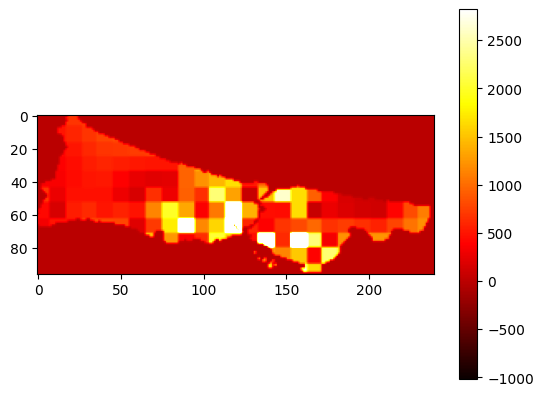

In [70]:
# visualize the data
import matplotlib.pyplot as plt
# calculate vmax and vmin using std dev of not 0 values

vmax = traffic_density_array[traffic_density_array != 0].mean() + 2 * traffic_density_array[traffic_density_array != 0].std()
vmin = traffic_density_array[traffic_density_array != 0].mean() - 2 * traffic_density_array[traffic_density_array != 0].std()

plt.imshow(traffic_density_array, cmap='hot', vmin=vmin, vmax=vmax)
plt.colorbar()

# 1.2. Load Air Pollution Rasters

In [71]:
import os
import cv2

air_pollution_folder = 'air_pollution_rasters_clipped'
air_pollution_files = os.listdir(air_pollution_folder)
# get only .tif files
air_pollution_files = [file for file in air_pollution_files if file.endswith('.tif')]

air_pollution_dict = {}
for file in air_pollution_files:
   air_pollution = gdal.Open(os.path.join(air_pollution_folder, file))
   air_pollution_band = air_pollution.GetRasterBand(1)
   air_pollution_array = air_pollution_band.ReadAsArray()
   
   resized_array = cv2.resize(air_pollution_array, (240, 96), interpolation=cv2.INTER_LINEAR)
   
   # Create dict key by removing _clipped from filename
   key = file.replace('_clipped', '').replace('.tif', '')
   air_pollution_dict[key] = resized_array

In [72]:
for key in air_pollution_dict.keys():
    print(key, air_pollution_dict[key].shape)
    # non zero value count
    print((air_pollution_dict[key] != 0).sum())
    
print(traffic_density_array.shape)
print((traffic_density_array != 0).sum())

co (96, 240)
9201
no2 (96, 240)
9201
nox (96, 240)
9201
no (96, 240)
9201
o3 (96, 240)
9201
pmo100 (96, 240)
8960
pmo2.5 (96, 240)
8960
so2 (96, 240)
9201
(96, 240)
9572


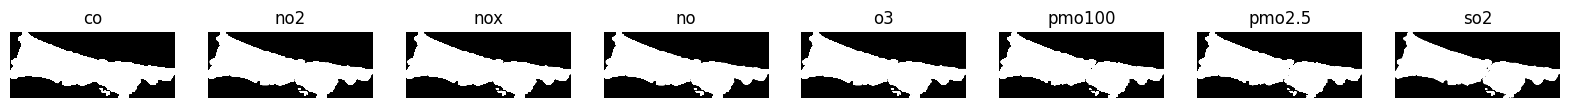

In [73]:
# visualize the all air pollution data
pollutant_count = len(air_pollution_dict.keys())
fig, axs = plt.subplots(1, pollutant_count, figsize=(20, 5))
for i, key in enumerate(air_pollution_dict.keys()):
    axs[i].imshow(air_pollution_dict[key], cmap='gray', vmin=0, vmax=1)
    axs[i].set_title(key)
    axs[i].axis('off')

plt.show()

In [74]:
# get zero value mask of every raster
# then get union of all masks
# then apply the mask to all rasters
# to get the same area for all rasters

zero_mask = traffic_density_array == 0
for key in air_pollution_dict.keys():
    zero_mask = zero_mask | (air_pollution_dict[key] == 0)

for key in air_pollution_dict.keys():
    air_pollution_dict[key][zero_mask] = 0

traffic_density_array[zero_mask] = 0

In [75]:
for key in air_pollution_dict.keys():
    print(key, air_pollution_dict[key].shape)
    # non zero value count
    print((air_pollution_dict[key] != 0).sum())
    
print(traffic_density_array.shape)
print((traffic_density_array != 0).sum())

co (96, 240)
8934
no2 (96, 240)
8934
nox (96, 240)
8934
no (96, 240)
8934
o3 (96, 240)
8934
pmo100 (96, 240)
8934
pmo2.5 (96, 240)
8934
so2 (96, 240)
8934
(96, 240)
8934


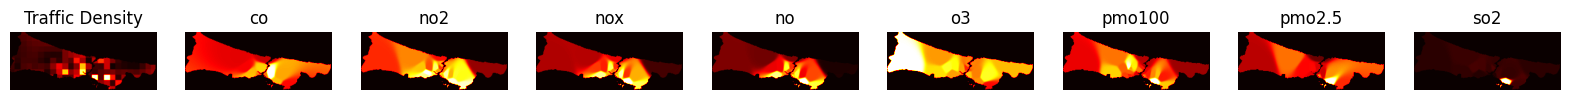

In [76]:
# visualize all air pollution rasters and traffic density raster. 
raster_count = len(air_pollution_dict.keys())
fig, axs = plt.subplots(1, raster_count + 1, figsize=(20, 5))

axs[0].imshow(traffic_density_array, cmap='hot')
axs[0].set_title('Traffic Density')
axs[0].axis('off')

for i, key in enumerate(air_pollution_dict.keys()):
    axs[i + 1].imshow(air_pollution_dict[key], cmap='hot')
    axs[i + 1].set_title(key)
    axs[i + 1].axis('off')

plt.show()

# 2. Correlation Analysis

## 2.1. Pearson Correlation Coefficient

In [77]:
# Calculate the correlation between traffic density and air pollutions
import numpy as np

# Pearson correlation coefficient
pearson_correlation_dict = {}
for key in air_pollution_dict.keys():
    # compare non zero values
    correlation = np.corrcoef(traffic_density_array[traffic_density_array != 0].flatten(), air_pollution_dict[key][air_pollution_dict[key] != 0].flatten())[0, 1]
    pearson_correlation_dict[key] = correlation

pearson_correlation_dict

{'co': 0.262743789376626,
 'no2': 0.4252153402348573,
 'nox': 0.45774765017933633,
 'no': 0.44283208003934377,
 'o3': -0.2212632304266793,
 'pmo100': 0.3339701591076674,
 'pmo2.5': 0.18483938283244156,
 'so2': 0.11127324981568512}

## 2.2. Kendall Tau correlation Coefficient

In [78]:
# Calculate kendall tau correlation
from scipy.stats import kendalltau

kendalltau_correlation_dict = {}

for key in air_pollution_dict.keys():
    # compare non zero values
    correlation = kendalltau(traffic_density_array[traffic_density_array != 0].flatten(), air_pollution_dict[key][air_pollution_dict[key] != 0].flatten())[0]
    #correlation, _ = kendalltau(traffic_density_array.flatten(), air_pollution_dict[key].flatten())
    kendalltau_correlation_dict[key] = correlation

kendalltau_correlation_dict

{'co': 0.09375230490648064,
 'no2': 0.3183935714058674,
 'nox': 0.342240669263711,
 'no': 0.31694852335254925,
 'o3': -0.16284037093369066,
 'pmo100': 0.29776284244207424,
 'pmo2.5': 0.11310320890596187,
 'so2': 0.23715528996162247}

# 3. Visualize Correlations

# 3.1. Visualize With Barchart

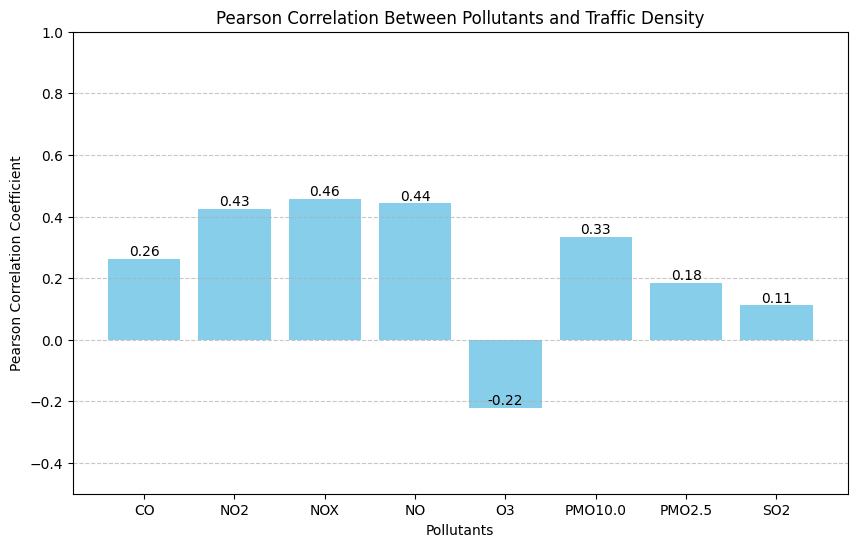

In [79]:
# make keys uppercase
keys = [key.upper() for key in pearson_correlation_dict.keys()]
keys[5] = "PMO10.0"
correlations = list(pearson_correlation_dict.values())


# Creating the bar chart with values displayed on the bars
plt.figure(figsize=(10, 6))
bars = plt.bar(keys, correlations, color='skyblue')

# Adding the probability values as text on top of each bar
for bar, correlation in zip(bars, correlations):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{correlation:.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.title('Pearson Correlation Between Pollutants and Traffic Density')
plt.xlabel('Pollutants')
plt.ylabel('Pearson Correlation Coefficient')
plt.ylim(-0.5, 1)  # Assuming correlation range is 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

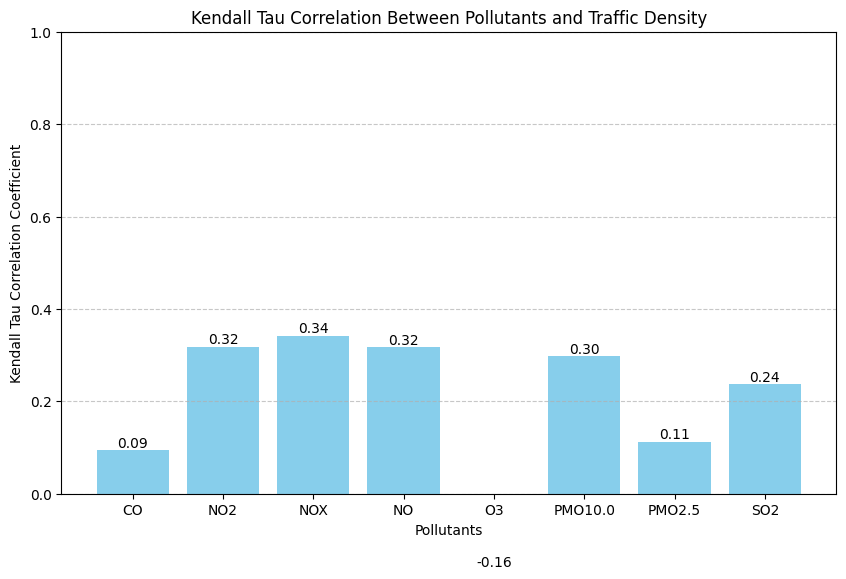

In [80]:
# make keys uppercase
keys = [key.upper() for key in kendalltau_correlation_dict.keys()]
keys[5] = "PMO10.0"
correlations = list(kendalltau_correlation_dict.values())

# Creating the bar chart with values displayed on the bars
plt.figure(figsize=(10, 6))
bars = plt.bar(keys, correlations, color='skyblue')

# Adding the probability values as text on top of each bar
for bar, correlation in zip(bars, correlations):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{correlation:.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.title('Kendall Tau Correlation Between Pollutants and Traffic Density')
plt.xlabel('Pollutants')
plt.ylabel('Kendall Tau Correlation Coefficient')
plt.ylim(0, 1)  # Assuming correlation range is 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 3.2. Visualize With Scatter Plot

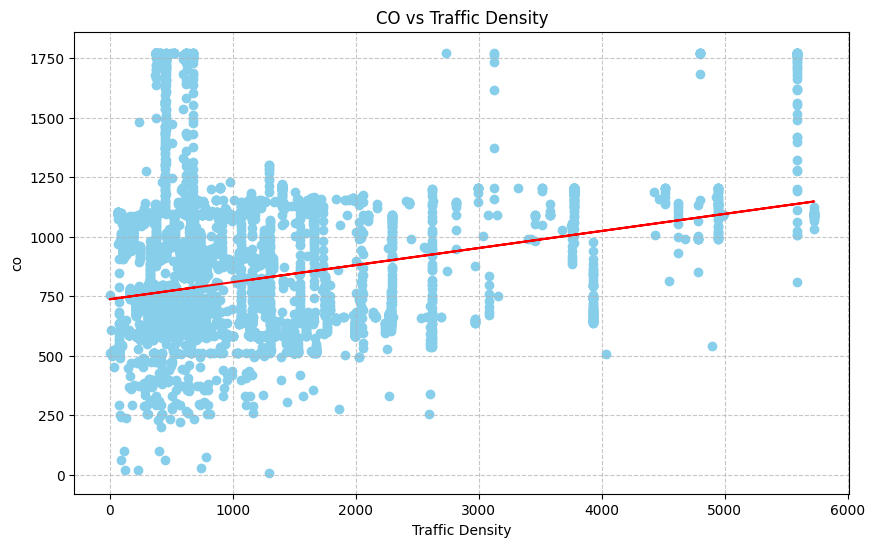

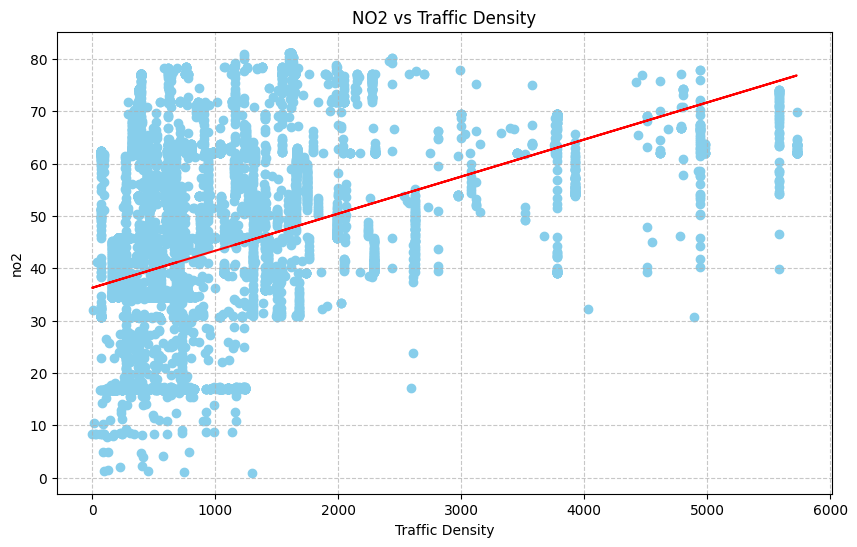

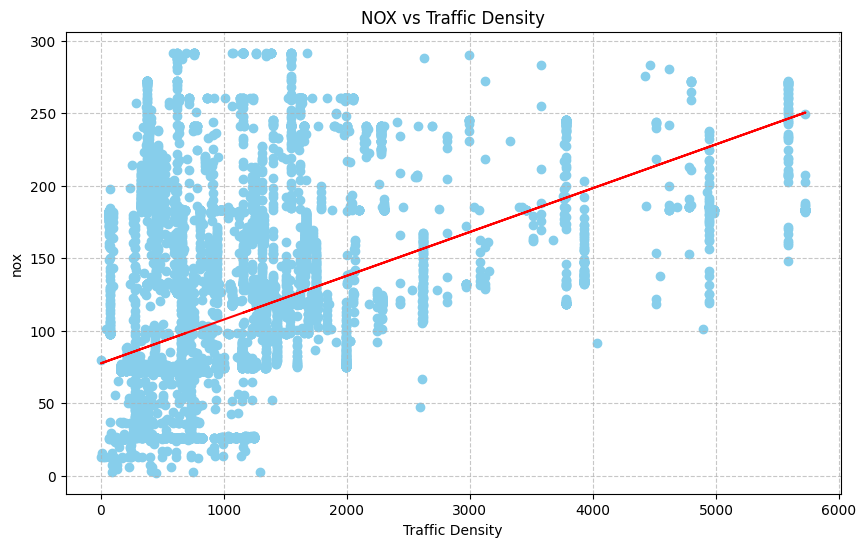

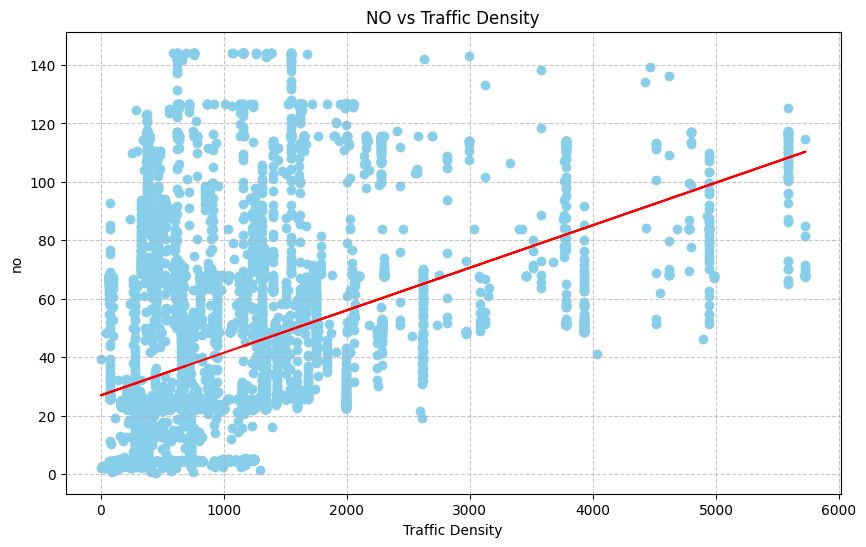

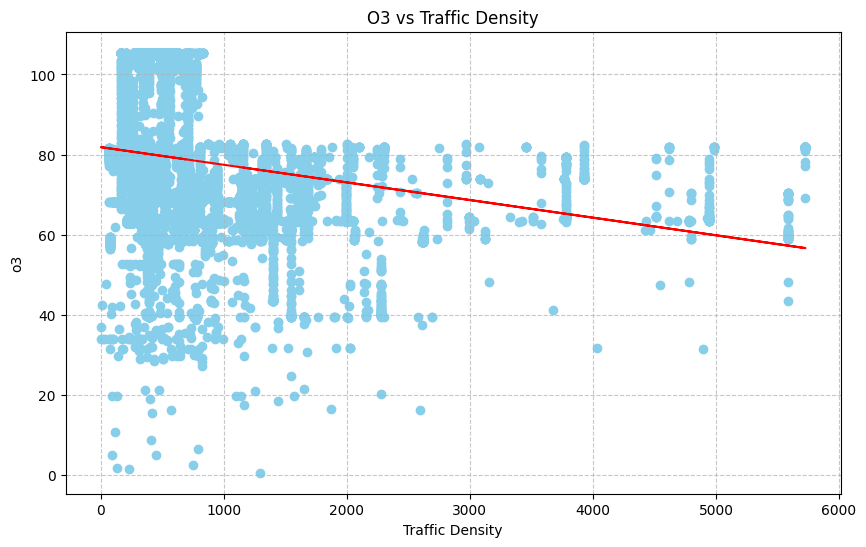

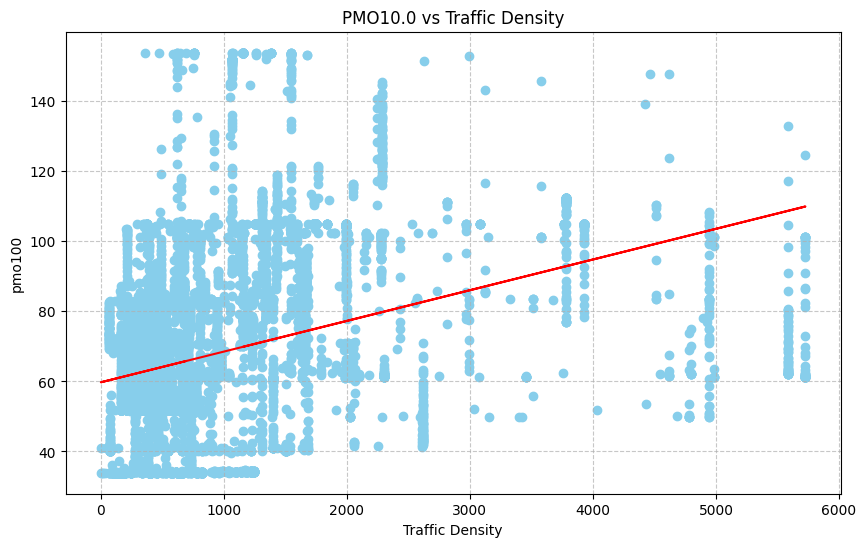

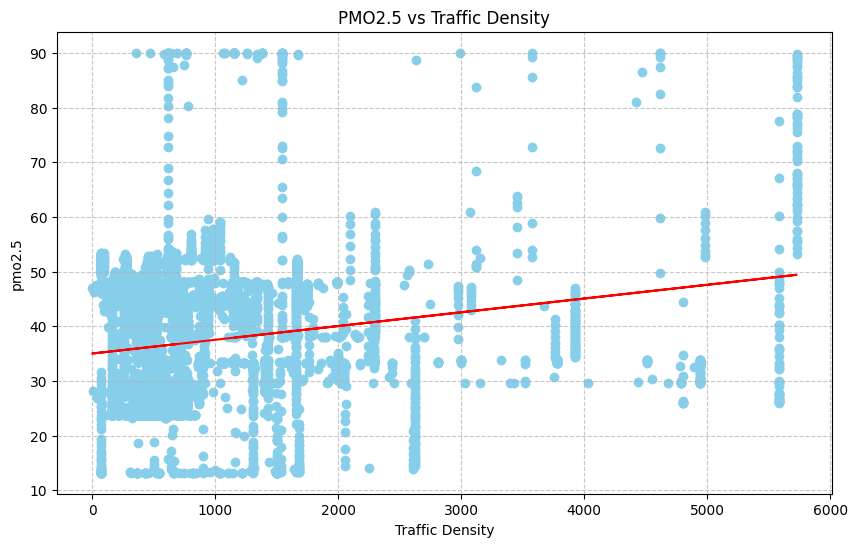

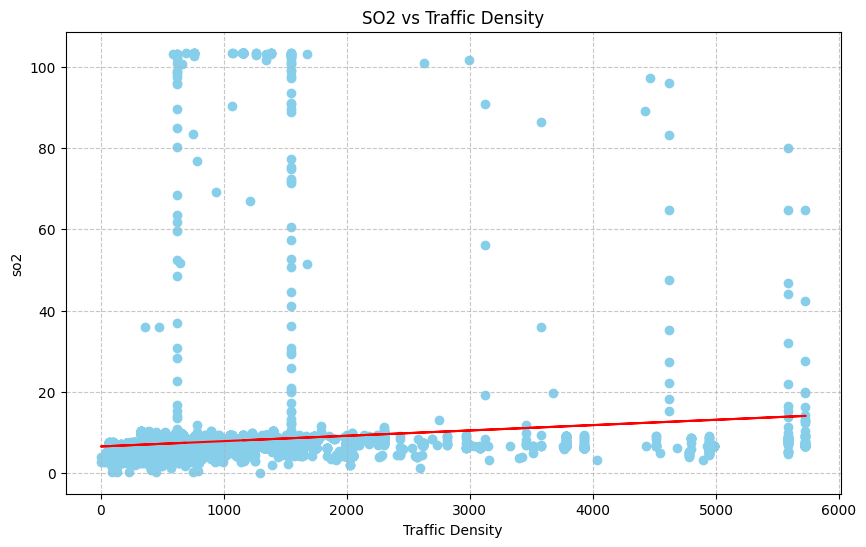

In [81]:
for i in range(len(air_pollution_dict)):
    key = list(air_pollution_dict.keys())[i]
    plt.figure(figsize=(10, 6))
    plt.scatter(traffic_density_array[traffic_density_array != 0].flatten(), air_pollution_dict[key][air_pollution_dict[key] != 0].flatten(), color='skyblue')

    # draw a line of best fit
    m, b = np.polyfit(traffic_density_array[traffic_density_array != 0].flatten(), air_pollution_dict[key][air_pollution_dict[key] != 0].flatten(), 1)
    plt.plot(traffic_density_array[traffic_density_array != 0].flatten(), m * traffic_density_array[traffic_density_array != 0].flatten() + b, color='red')

    plt.title(f'{keys[i]} vs Traffic Density')
    plt.xlabel('Traffic Density')
    plt.ylabel(key)
    plt.grid(axis='both', linestyle='--', alpha=0.7)
    plt.show()

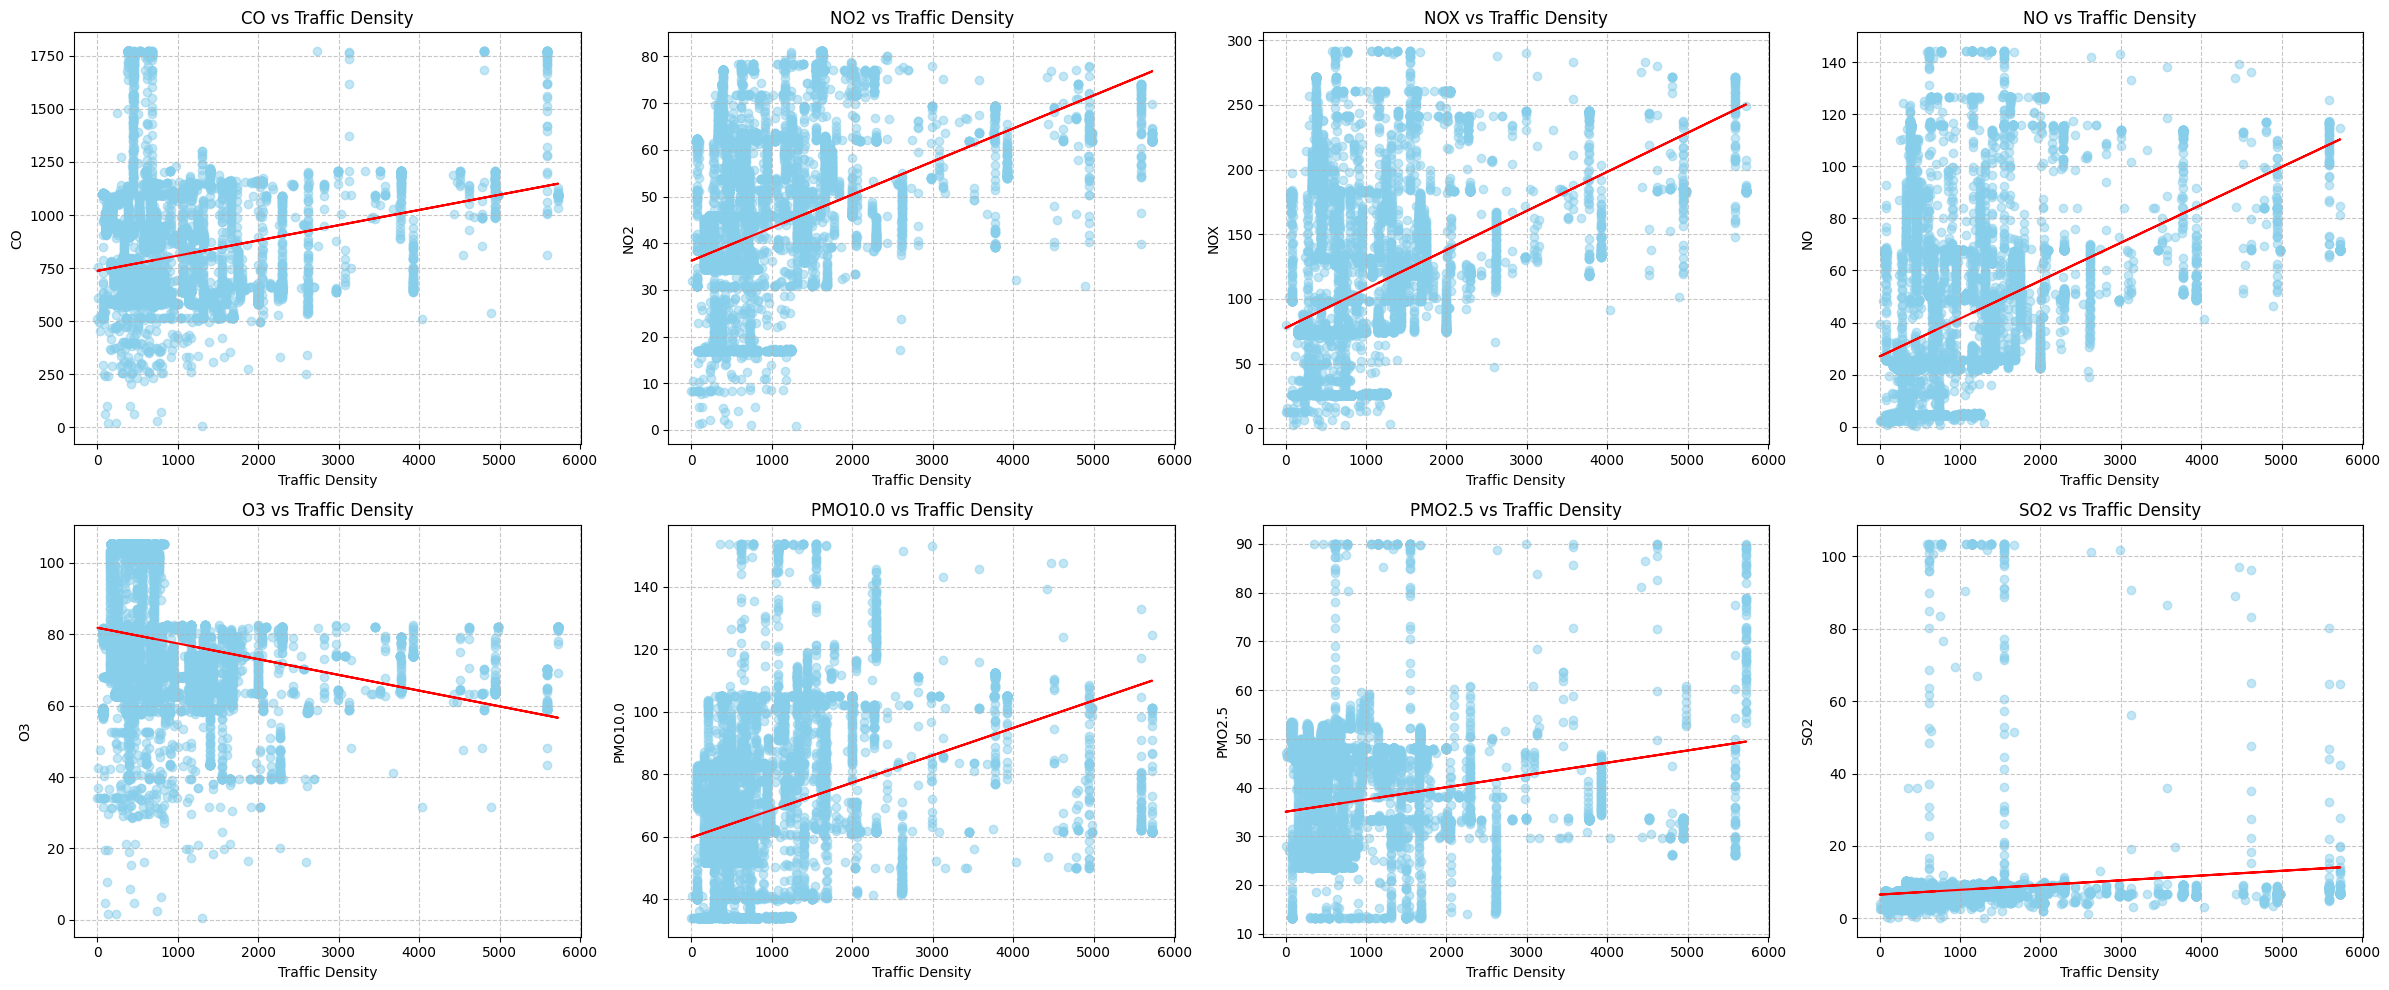

In [90]:
fig, axs = plt.subplots(2, 4, figsize=(24, 10))
axs = axs.ravel()

for i, key in enumerate(air_pollution_dict.keys()):
   x = traffic_density_array[traffic_density_array != 0].flatten()
   y = air_pollution_dict[key][air_pollution_dict[key] != 0].flatten()
   
   axs[i].scatter(x, y, color='skyblue', alpha=0.5)
   
   m, b = np.polyfit(x, y, 1)
   axs[i].plot(x, m * x + b, color='red')
   
   axs[i].set_title(f'{keys[i]} vs Traffic Density')
   axs[i].set_xlabel('Traffic Density')
   axs[i].set_ylabel(keys[i])
   axs[i].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

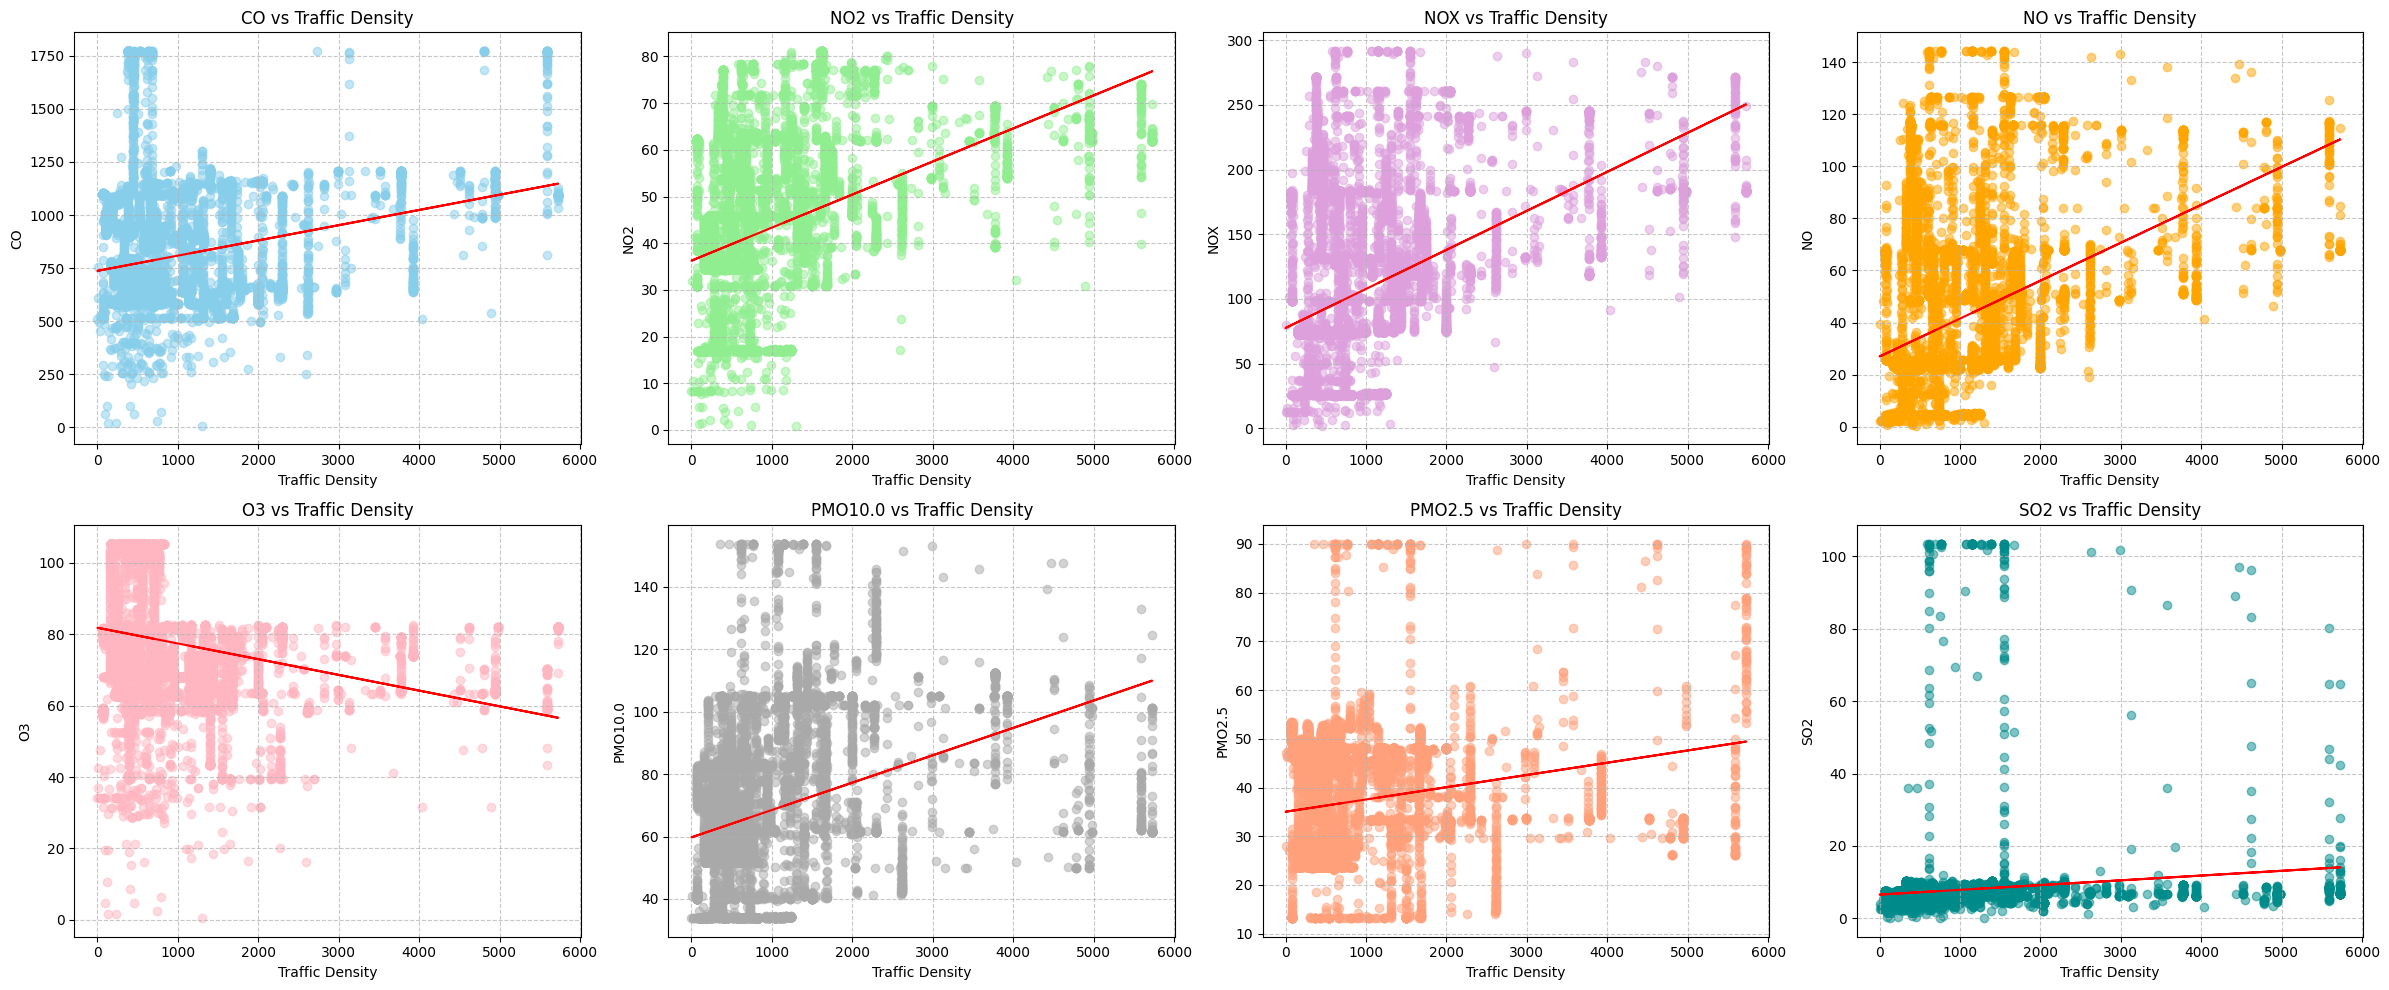

In [95]:
colors = ['skyblue', 'lightgreen', 'plum', 'orange', 'lightpink', 'darkgray', 'lightsalmon', 'darkcyan']

fig, axs = plt.subplots(2, 4, figsize=(24, 10))
axs = axs.ravel()

for i, key in enumerate(air_pollution_dict.keys()):
   x = traffic_density_array[traffic_density_array != 0].flatten()
   y = air_pollution_dict[key][air_pollution_dict[key] != 0].flatten()
   
   axs[i].scatter(x, y, color=colors[i], alpha=0.5)
   
   m, b = np.polyfit(x, y, 1)
   axs[i].plot(x, m * x + b, color='red')
   
   axs[i].set_title(f'{keys[i]} vs Traffic Density')
   axs[i].set_xlabel('Traffic Density')
   axs[i].set_ylabel(keys[i])
   axs[i].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

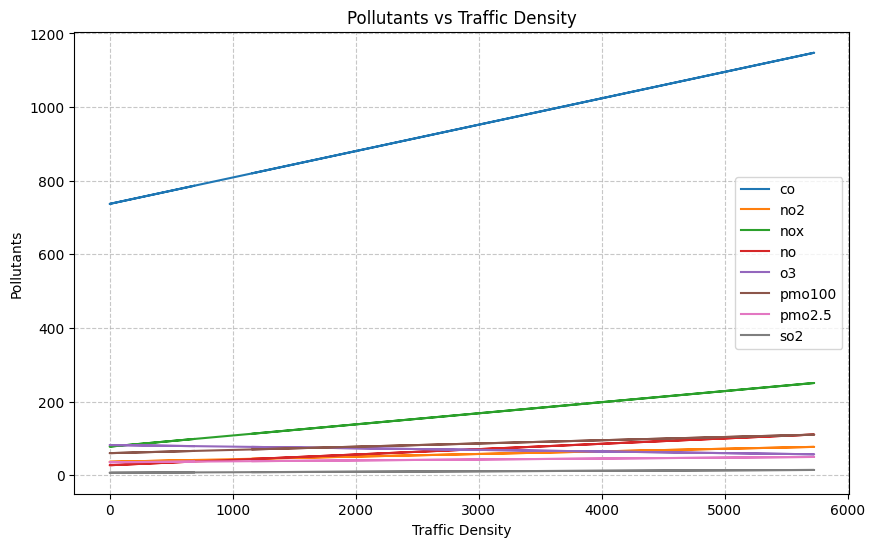

In [61]:
# draw all lines of best fit in one plot
plt.figure(figsize=(10, 6))
for i in range(len(air_pollution_dict)):
    key = list(air_pollution_dict.keys())[i]
    # plt.scatter(traffic_density_array[traffic_density_array != 0].flatten(), air_pollution_dict[key][air_pollution_dict[key] != 0].flatten(), color='skyblue')

    # draw a line of best fit
    m, b = np.polyfit(traffic_density_array[traffic_density_array != 0].flatten(), air_pollution_dict[key][air_pollution_dict[key] != 0].flatten(), 1)
    plt.plot(traffic_density_array[traffic_density_array != 0].flatten(), m * traffic_density_array[traffic_density_array != 0].flatten() + b, label=key)

plt.title('Pollutants vs Traffic Density')
plt.xlabel('Traffic Density')
plt.ylabel('Pollutants')
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

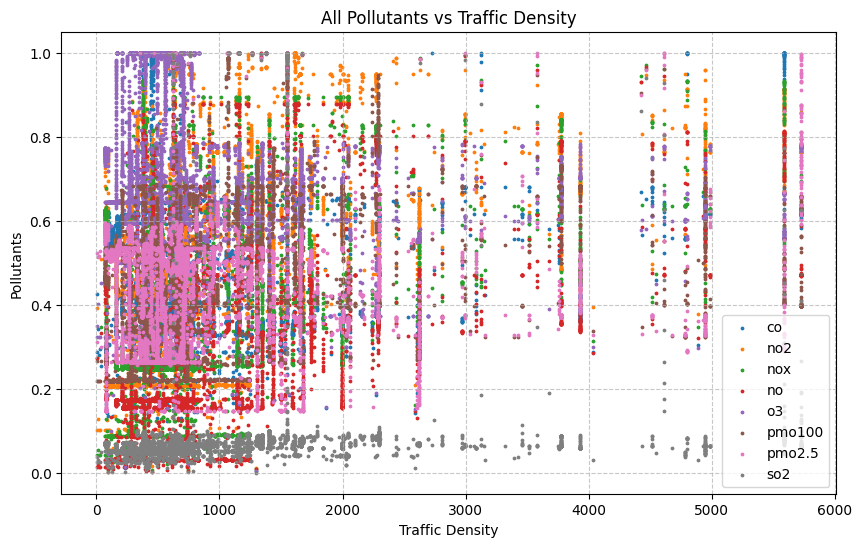

In [ ]:
normalized_air_pollution_dict = air_pollution_dict.copy()
plt.figure(figsize=(10, 6))
for i in range(len(normalized_air_pollution_dict)):
    key = list(normalized_air_pollution_dict.keys())[i]
    # normalize the data using min max scaling
    normalized_air_pollution_dict[key] = (normalized_air_pollution_dict[key] - normalized_air_pollution_dict[key].min()) / (normalized_air_pollution_dict[key].max() - normalized_air_pollution_dict[key].min())
    plt.scatter(traffic_density_array[traffic_density_array != 0].flatten(), normalized_air_pollution_dict[key][normalized_air_pollution_dict[key] != 0].flatten(), label=key, s=3)
    # plt.scatter(traffic_density_array[traffic_density_array != 0].flatten(), air_pollution_dict[key][air_pollution_dict[key] != 0].flatten(), label=key, s=1)

plt.title('All Pollutants vs Traffic Density')
plt.xlabel('Traffic Density')
plt.ylabel('Pollutants')
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show() 